In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import preprocessing
from sklearn import metrics

import random
from scipy import stats
import shap

pd.set_option('display.max_rows',2000)
pd.set_option('display.max_columns',2000)

/opt/anaconda3/envs/obesity_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* 국민건강영양조사 원시자료 2016 ~ 2018 (7기)

In [2]:
data_16 = pd.read_csv("Data/hn2016_all.csv",encoding='utf-8', low_memory=False)
data_17 = pd.read_csv("Data/hn2017_all.csv",encoding='utf-8', low_memory=False)
data_18 = pd.read_csv("Data/hn2018_all.csv",encoding='utf-8', low_memory=False)
# data_19 = pd.read_csv("Data/hn2019_all.csv",encoding='utf-8', low_memory=False)
print(data_16.shape, data_17.shape, data_18.shape)

(6382, 800) (6518, 858) (6489, 786)


In [3]:
data = pd.concat([data_16, data_17, data_18], axis=0).reset_index()
data.drop(['index'], axis=1, inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19389 entries, 0 to 19388
Columns: 922 entries, mod_d to HE_UNa_etc
dtypes: float64(1), int64(19), object(902)
memory usage: 136.4+ MB


결측치 확인

# 결측치

* 데이터 별로 특정 년도에만 해당하는 변수들이 있음 -> 해당 컬럼 제거

```
    # 6382 -> 16년도 자료에 없음
    # 6518 -> 17년 자료에 없음
    # 6489개 -> 18년도 자료에 없음
    # 13007개 -> 17, 18년도 자료에 없음
    # 12871 -> 16, 18년도 자료에 없음
    # 12900 -> 16, 17년도 자료에 없음
```

In [5]:
null_df = pd.DataFrame(data.isnull().sum())
tmp = pd.DataFrame(data.isnull().sum() > 0, columns = ['null'])
null_idx = tmp[tmp['null'] == True].index
print(len(null_idx)) # 191개
null_df.loc[null_idx, :].value_counts()

191


12871    82
13007    28
6489     26
12900    21
6382     19
6518     15
dtype: int64

In [6]:
null_df.loc[null_idx, :].head(10)

,0
wt_hm,6489
wt_pfhm,6489
wt_hmnt,6489
wt_pfhmnt,6489
id_f,6489
id_m,6489
BH1_1,13007
BH1_2,13007
BH1_3,13007
BH1_8,13007


In [7]:
# 위의 결측치 제거
data.drop(null_idx, axis=1, inplace=True)
print(data.shape) # 731 columns
data.drop(['mod_d',	'ID','ID_fam','year','region','town_t','apt_t','psu','age_month'], axis=1, inplace=True)
print(data.shape)

(19389, 731)
(19389, 722)


In [8]:
# nan이 아닌 빈칸들이 보임
data.head()

,sex,age,incm,ho_incm,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,wt_pft,wt_ntr,wt_tot,wt_pfnt,wt_nn,wt_nnnt,wt_vt,wt_pfvt,wt_vtnt,wt_pfvtnt,kstrata,cfam,genertn,allownc,house,live_t,ainc_unit1,ainc_1,ainc,marri_1,marri_2,fam_rela,tins,npins,D_1_1,D_2_1,D_2_wk,DI1_dg,DI1_ag,DI1_pr,DI1_pt,DI1_2,DI2_dg,DI2_ag,DI2_pr,DI2_pt,DI2_2,DI3_dg,DI3_ag,DI3_pr,DI3_pt,DI3_2,DI4_dg,DI4_pr,DI4_pt,DI5_dg,DI5_ag,DI5_pr,DI5_pt,DI6_dg,DI6_ag,DI6_pr,DI6_pt,DM1_dg,DM1_pr,DM1_pt,DM2_dg,DM2_ag,DM2_pr,DM2_pt,DM3_dg,DM3_ag,DM3_pr,DM3_pt,DM4_dg,DM4_ag,DM4_pr,DM4_pt,DJ2_dg,DJ2_ag,DJ2_pr,DJ2_pt,DJ4_dg,DJ4_ag,DJ4_pr,DJ4_pt,DJ4_3,DE1_dg,DE1_ag,DE1_pr,DE1_pt,DE1_3,DE1_31,DE1_32,DE1_33,DE1_34,DE1_35,DE1_4,DE2_dg,DE2_ag,DE2_pr,DE2_pt,DC1_dg,DC1_ag,DC1_pr,DC1_pt,DC2_dg,DC2_ag,DC2_pr,DC2_pt,DC3_dg,DC3_ag,DC3_pr,DC3_pt,DC4_dg,DC4_ag,DC4_pr,DC4_pt,DC5_dg,DC5_ag,DC5_pr,DC5_pt,DC6_dg,DC6_ag,DC6_pr,DC6_pt,DC7_dg,DC7_ag,DC7_pr,DC7_pt,DC11_tp,DC11_dg,DC11_ag,DC11_pr,DC11_pt,DF2_dg,DF2_ag,DF2_pr,DF2_pt,DL1_dg,DL1_ag,DL1_pr,DL1_pt,DJ8_dg,DJ8_ag,DJ8_pr,DJ8_pt,DJ6_dg,DJ6_ag,DJ6_pr,DJ6_pt,DH4_dg,DH4_ag,DH4_pr,DH4_pt,DH2_dg,DH2_ag,DH2_pr,DH2_pt,DH3_dg,DH3_ag,DH3_pr,DH3_pt,DH6_dg,DH6_ag,DH6_pr,DH6_pt,DN1_dg,DN1_ag,DN1_pr,DN1_pt,DK8_dg,DK8_ag,DK8_pr,DK8_pt,DK9_dg,DK9_ag,DK9_pr,DK9_pt,DK4_dg,DK4_ag,DK4_pr,DK4_pt,DI9_yd,DI9_ya,DF1_yd,DF1_ya,DN6_yd,DN6_ya,DJ9_yd,DJ9_ya,M_2_yr,M_2_rs,M_2_et,mt_nontrt,BH9_11,BH9_13,BH9_14_1_01,BH9_14_2_01,BH9_14_3_01,BH9_14_4_01,BH9_14_1_02,BH9_14_2_02,BH9_14_3_02,BH9_14_4_02,BH1,BH2_61,LQ4_00,LQ4_01,LQ4_02,LQ4_03,LQ4_04,LQ4_05,LQ4_06,LQ4_07,LQ4_08,LQ4_09,LQ4_10,LQ4_11,LQ4_12,LQ4_13,LQ4_14,LQ4_15,LQ4_16,LQ4_21,LQ4_22,LQ4_25,LQ4_26,LQ4_27,LQ4_28,LQ4_29,LQ4_23,LQ4_24,LQ4_17,LQ4_18,LQ4_19,LQ4_20,LQ1_sb,LQ1_mn,LQ2_ab,LQ2_mn,LQ_1EQL,LQ_2EQL,LQ_3EQL,LQ_4EQL,LQ_5EQL,EQ5D,AC1_yr,AC3,AC3_1_01,AC3_1_02,AC3_1_03,AC3_2_01,AC3_2_02,AC3_2_03,AC3_3_01,AC3_3_02,AC3_3_03,AC3_3e_01,AC3_3e_02,AC3_3e_03,AC8_1_01,AC8_1_02,AC8_1_03,AC8_1e_01,AC8_1e_02,AC8_1e_03,AC3_4_01,AC3_4_02,AC3_4_03,AC8_2w_01,AC8_2w_02,AC8_2w_03,AC8_2_01,AC8_2_02,AC8_2_03,AC8_3w_01,AC8_3w_02,AC8_3w_03,AC8_3_01,AC8_3_02,AC8_3_03,ij_expr,MH1_yr,MH1_1,MO1_wk,MO1_1,educ,graduat,CH2_1,CH2_2,EC1_1,EC_occp,EC_stt_1,EC_stt_2,EC_wht_0,EC_wht_23,EC_wht_5,EC_wht_6,EC_lgw_2,EC_lgw_4,EC_lgw_5,EC_pedu_1,EC_pedu_2,BO1,BO1_1,BO1_2,BO1_3,BO2_1,BO3_01,BO3_02,BO3_03,BO3_14,BO3_05,BO3_04,BO3_12,BO3_07,BO3_09,BO3_10,BO3_11,BD1,BD2,BD1_11,BD2_1,BD2_31,BD2_32,BD7_4,BD7_5,dr_month,BA2_12,BA2_13,BA1_3,BA1_5,BA2_2_1,BA2_2_2,BA2_2_3,BA2_2_4,BA2_2_5,BA2_2_6,BA2_22,BA1_1,BA1_2,sc_seatblt,sc_seatblt2,BP16_11,BP16_12,BP16_13,BP16_14,BP16_21,BP16_22,BP16_23,BP16_24,Total_slp_wk,Total_slp_wd,BP1,BP5,BP6_10,BP6_2,BP6_31,BP7,mh_stress,BS1_1,BS2_1,BS3_1,BS3_2,BS3_3,BS6_2,BS6_2_1,BS6_2_2,BS6_3,BS6_4,BS6_4_1,BS6_4_2,BS5,BS5_1,BS5_5,BS5_21,BS5_28,BS5_26,BS5_33,BS5_34,BS5_32,BS5_29,BS5_30,BS5_31,BS8_2,BS9_2,BS13,BS12_1,BS12_2,BS12_31,BS12_32,BS12_33,BS12_34,BS12_35,BS12_36,BS12_41,BS12_42,BS12_43,BS12_44,BS12_45,BS12_46,BS10_1,BS2,BS10_2,BS10_3,sm_presnt,BE3_71,BE3_72,BE3_73,BE3_74,BE3_81,BE3_82,BE3_83,BE3_84,BE3_91,BE3_92,BE3_93,BE3_94,BE3_75,BE3_76,BE3_77,BE3_78,BE3_85,BE3_86,BE3_87,BE3_88,BE8_1,BE8_2,BE3_31,BE3_32,BE3_33,BE5_1,pa_aerobic,LW_ms,LW_mp_e,LW_mp_a,LW_ms_a,LW_pr,LW_pr_1,LW_mt,LW_mt_a1,LW_mt_a2,LW_br,LW_br_ch,LW_br_dur,LW_br_yy,LW_br_mm,LW_oc,HE_fst,HE_HPdg,HE_HPdr,HE_DMdg,HE_DMdr,HE_mens,HE_prg,HE_dprg,HE_fh,HE_HPfh1,HE_HPfh2,HE_HPfh3,HE_HLfh1,HE_HLfh2,HE_HLfh3,HE_IHDfh1,HE_IHDfh2,HE_IHDfh3,HE_STRfh1,HE_STRfh2,HE_STRfh3,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_THfh1,HE_THfh2,HE_THfh3,HE_HBfh1,HE_HBfh2,HE_HBfh3,HE_rPLS,HE_PLS,HE_mPLS,HE_nARM,HE_sbp1,HE_dbp1,HE_sbp2,HE_dbp2,HE_sbp3,HE_dbp3,HE_sbp,HE_dbp,HE_HP,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_wt_pct,HE_BMI_pct,HE_glu,HE_HbA1c,HE_DM,HE_chol,HE_HDL_st2,HE_TG,HE_LDL_drct,HE_HCHOL,HE_HTG,HE_HBsAg,HE_ast,HE_alt,HE_hepaB,HE_hcv,HE_hepaC,HE_HB,HE_HCT,HE_anem,HE_BUN,HE_crea,HE_WBC,HE_RBC,HE_Bplt,HE_hsCRP,HE_Uacid,HE_Folate,HE_VitA,HE_VitE,HE_Uph,HE_Unitr,HE_Usg,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ub

# ' '등으로 채워진 빈칸을 NaN으로 바꿔줌
```
data.replace(' ', np.nan, inplace=True) 등으로 처리할 경우, ' ', '  ' 등등을 다 따로 처리해줘야함
```

In [9]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype(float).round(2)

In [10]:
null_df = pd.DataFrame(data.isnull().sum())
tmp = pd.DataFrame(data.isnull().sum() > 0, columns=['null'])
null_idx = tmp[tmp['null'] == True].index
print(len(null_idx)) # 706개
null_df.loc[null_idx, :].value_counts()
# 836개, 903개 등등 겹치는건 row를 제거하는게 효과적일것임
# 살릴 수 있는 데이터는 살리면 좋으니까, 100개 이하인 데이터에 대해서 impute 진행

706


836      366
19389     44
2535      36
903       22
2520      16
11843     16
2536      15
8963      14
831       13
897       10
1692       9
18200      9
19323      9
19382      9
1536       8
829        7
1577       7
74         5
8570       4
1704       3
19314      3
11639      3
19296      3
1706       3
8585       3
12963      2
898        2
791        2
8625       1
10973      1
9815       1
990        1
1116       1
12037      1
8536       1
7936       1
6647       1
6646       1
6645       1
906        1
12964      1
12713      1
4496       1
12969      1
13571      1
13803      1
16064      1
16466      1
16623      1
17984      1
900        1
18814      1
19028      1
19299      1
857        1
5298       1
2575       1
3348       1
1082       1
1816       1
1806       1
1804       1
1763       1
1752       1
1693       1
1084       1
1145       1
1560       1
1546       1
1543       1
1539       1
1537       1
1115       1
1817       1
1862       1
1865       1
1867       1

In [11]:
# 만개 가까이 되는것들은 columns을 drop
# 갯수가 작은것은 row를 drop

remove_col = null_df[null_df > 2000].dropna().index
data.drop(remove_col, axis=1, inplace=True)

In [12]:
remove_row = null_df[(null_df < 100) & (null_df >0)].dropna().index

In [13]:
# 결측치 100개 이하는 random sampling으로 impute
def random_value_imputation(feature):
    random_sample = data[feature].dropna().sample(data[feature].isna().sum())
    random_sample.index = data[data[feature].isnull()].index
    data.loc[data[feature].isnull(), feature] = random_sample

for col in remove_row:
    random_value_imputation(col)
    
print(data.shape)
# 결측치 100개 impute 한 결과
# 14693 rows -> 14727 rows 

(19389, 503)


In [14]:
data.dropna(how='any', inplace=True)

In [15]:
data

,sex,age,incm,ho_incm,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,kstrata,cfam,genertn,allownc,house,live_t,ainc_unit1,ainc_1,ainc,marri_1,marri_2,fam_rela,tins,npins,D_1_1,D_2_1,D_2_wk,DI1_dg,DI1_ag,DI1_pr,DI1_pt,DI1_2,DI2_dg,DI2_ag,DI2_pr,DI2_pt,DI2_2,DI3_dg,DI3_ag,DI3_pr,DI3_pt,DI3_2,DI4_dg,DI4_pr,DI4_pt,DI5_dg,DI5_ag,DI5_pr,DI5_pt,DI6_dg,DI6_ag,DI6_pr,DI6_pt,DM1_dg,DM1_pr,DM1_pt,DM2_dg,DM2_ag,DM2_pr,DM2_pt,DM3_dg,DM3_ag,DM3_pr,DM3_pt,DM4_dg,DM4_ag,DM4_pr,DM4_pt,DJ2_dg,DJ2_ag,DJ2_pr,DJ2_pt,DJ4_dg,DJ4_ag,DJ4_pr,DJ4_pt,DJ4_3,DE1_dg,DE1_ag,DE1_pr,DE1_pt,DE1_3,DE1_31,DE1_32,DE1_33,DE1_34,DE1_4,DE2_dg,DE2_ag,DE2_pr,DE2_pt,DC1_dg,DC1_ag,DC1_pr,DC1_pt,DC2_dg,DC2_ag,DC2_pr,DC2_pt,DC3_dg,DC3_ag,DC3_pr,DC3_pt,DC4_dg,DC4_ag,DC4_pr,DC4_pt,DC5_dg,DC5_ag,DC5_pr,DC5_pt,DC6_dg,DC6_ag,DC6_pr,DC6_pt,DC7_dg,DC7_ag,DC7_pr,DC7_pt,DC11_dg,DC11_ag,DC11_pr,DC11_pt,DF2_dg,DF2_ag,DF2_pr,DF2_pt,DL1_dg,DL1_ag,DL1_pr,DL1_pt,DJ8_dg,DJ8_ag,DJ8_pr,DJ8_pt,DJ6_dg,DJ6_ag,DJ6_pr,DJ6_pt,DH4_dg,DH4_ag,DH4_pr,DH4_pt,DH2_dg,DH2_ag,DH2_pr,DH2_pt,DH3_dg,DH3_ag,DH3_pr,DH3_pt,DH6_dg,DH6_ag,DH6_pr,DH6_pt,DN1_dg,DN1_ag,DN1_pr,DN1_pt,DK8_dg,DK8_ag,DK8_pr,DK8_pt,DK9_dg,DK9_ag,DK9_pr,DK9_pt,DK4_dg,DK4_ag,DK4_pr,DK4_pt,DI9_yd,DI9_ya,DF1_yd,DF1_ya,DN6_yd,DN6_ya,DJ9_yd,DJ9_ya,M_2_yr,M_2_rs,BH9_11,BH9_13,BH1,BH2_61,LQ4_00,LQ4_01,LQ4_02,LQ4_03,LQ4_04,LQ4_05,LQ4_06,LQ4_07,LQ4_08,LQ4_09,LQ4_10,LQ4_11,LQ4_12,LQ4_13,LQ4_14,LQ4_15,LQ4_16,LQ4_21,LQ4_22,LQ4_25,LQ4_26,LQ4_27,LQ4_28,LQ4_29,LQ4_23,LQ4_17,LQ4_18,LQ4_19,LQ4_20,LQ1_sb,LQ1_mn,LQ2_ab,LQ2_mn,LQ_1EQL,LQ_2EQL,LQ_3EQL,LQ_4EQL,LQ_5EQL,EQ5D,AC1_yr,AC3,ij_expr,MH1_yr,MH1_1,MO1_wk,MO1_1,educ,graduat,CH2_1,CH2_2,EC1_1,EC_occp,EC_stt_1,EC_stt_2,EC_wht_0,EC_wht_23,EC_wht_5,EC_lgw_2,EC_lgw_4,EC_lgw_5,EC_pedu_1,EC_pedu_2,BO1,BO1_1,BO1_2,BO1_3,BO2_1,BO3_01,BO3_02,BO3_03,BO3_14,BO3_05,BO3_04,BO3_12,BO3_07,BO3_09,BO3_10,BD1,BD2,BD1_11,BD2_1,BD2_31,BD2_32,BD7_4,BD7_5,dr_month,BA2_12,BA2_13,BA1_3,BA1_5,BA2_2_1,BA2_2_2,BA2_2_3,BA2_2_4,BA2_2_5,BA2_2_6,BA2_22,BA1_1,BA1_2,sc_seatblt2,BP16_11,BP16_12,BP16_13,BP16_14,BP16_21,BP16_22,BP16_23,BP16_24,Total_slp_wk,Total_slp_wd,BP1,BP5,BP6_10,BP6_2,BP6_31,BP7,mh_stress,BS1_1,BS2_1,BS3_1,BS3_2,BS3_3,BS6_2,BS6_2_1,BS6_2_2,BS6_3,BS6_4,BS6_4_1,BS6_4_2,BS5,BS5_1,BS5_5,BS5_21,BS5_28,BS5_26,BS5_33,BS5_34,BS5_32,BS5_29,BS5_30,BS8_2,BS9_2,BS13,BS12_1,BS12_2,BS12_31,BS12_32,BS12_33,BS12_34,BS12_36,BS12_41,BS12_42,BS12_43,BS12_44,BS12_46,BS10_1,BS2,BS10_2,BS10_3,sm_presnt,BE3_71,BE3_72,BE3_73,BE3_74,BE3_81,BE3_82,BE3_83,BE3_84,BE3_91,BE3_92,BE3_93,BE3_94,BE3_75,BE3_76,BE3_77,BE3_78,BE3_85,BE3_86,BE3_87,BE3_88,BE8_1,BE8_2,BE3_31,BE3_32,BE3_33,BE5_1,pa_aerobic,HE_fst,HE_HPdg,HE_HPdr,HE_DMdg,HE_DMdr,HE_mens,HE_prg,HE_fh,HE_HPfh1,HE_HPfh2,HE_HPfh3,HE_HLfh1,HE_HLfh2,HE_HLfh3,HE_IHDfh1,HE_IHDfh2,HE_IHDfh3,HE_STRfh1,HE_STRfh2,HE_STRfh3,HE_DMfh1,HE_DMfh2,HE_DMfh3,HE_THfh1,HE_THfh2,HE_THfh3,HE_HBfh1,HE_HBfh2,HE_HBfh3,HE_rPLS,HE_nARM,HE_sbp1,HE_dbp1,HE_sbp2,HE_dbp2,HE_sbp3,HE_dbp3,HE_sbp,HE_dbp,HE_HP,HE_ht,HE_wt,HE_wc,HE_BMI,HE_obe,HE_glu,HE_HbA1c,HE_chol,HE_HDL_st2,HE_TG,HE_HBsAg,HE_ast,HE_alt,HE_hepaB,HE_hcv,HE_hepaC,HE_HB,HE_HCT,HE_anem,HE_BUN,HE_crea,HE_WBC,HE_RBC,HE_Bplt,HE_Uacid,HE_Uph,HE_Unitr,HE_Usg,HE_Upro,HE_Uglu,HE_Uket,HE_Ubil,HE_Ubld,HE_Uro,HE_UCREA,BM1_0,BM1_1,BM1_2,BM1_3,BM1_4,BM1_5,BM1_6,BM1_7,BM1_8,BM2_1,BM2_3,BM2_2,BM2_4,BM2_5,BM13,BM13_1,BM13_2,BM13_3,BM13_4,BM13_5,BM7,O_chew_d,BM8,OR1_2,MO4_00,MO4_4,MO4_9,MO4_7,MO4_8,MO4_17,MO4_11,MO4_12,MO4_18,MO4_15,BM14,BM14_1,T_Q_HR,T_Q_HR1,T_Q_VN,T_Q_VN1,T_NQ_PH,T_NQ_PH_T,T_NQ_OCP,T_NQ_OCP_T,T_NQ_OCP_P,T_NQ_LS,T_NQ_LS_T,T_NQ_FIR,T_NQ_FIR_P,GS_use,GS_mea_r_1,GS_mea_r_2,GS_mea_r_3,GS_mea_l_1,GS_mea_l_2,GS_mea_l_3
0,1.0,61.0,3.0,3.0,4.0,4.0,4.0,7.0,3981.18,7446.34,701.0,3.0,4.0,20.0,2.0,2.0,2.0,500.0,500.00,1.0,1.0,1.0,10.0,1.0,3.0,2.0,88.0,1.0,47.0,1.0,1.0,1.0,0.0,888.0,8.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,0.0,8.0,8.0,0.0,888.0,8.0,8.0,0.0,888.0,8.0,8.0,0.0,8.0,8.0,0.0,888.0,8.0,8.0,0.0,888.0,8.0,8.0,0.0,888.0,8.0,8.0,0.0,888.0,8.0,8.0,0.0,888.0,8.0,8.0,8.0,1.0,52.0,1.0,1.0,

```
# 초반에 제거하면 너무 많은 데이터가 제거되는 문제가 생김
# 비해당과 상관관계가 있을까?
# 무응답은 결측치로 처리
# 비해당은 그냥 둘까?
# 8, 9가 선택지인 경우가 많음(FF_BARLEY, FF_BEER 등)
# 8, 9라고 막 지우면 안됨
# 데이터를 살펴보니 갯수가 11개보다 작으면 설문조사로 판단할 수 있을 것 같음
```

|value|discription|
|:---|:---|
| 888 | 비해당 |
| 999 | 모름 / 무응답 |
| 88 | 비해당 |
| 99 | 무응답 |
| 8 | 비해당 |
| 9 | 모름 / 무응답 |

In [16]:
# 88, 99, 888, 999는 np.nan으로 변환 후 결측치 개수 확인
# 88, 99 등으로 group_by 한다음에 확인할 수 있나? -> 변수가 너무 많아서 힘들것같음
data.replace(88, np.nan, inplace=True)
data.replace(99, np.nan, inplace=True)
data.replace(888, np.nan, inplace=True)
data.replace(999, np.nan, inplace=True)

tmp = pd.DataFrame(data.isnull().sum(), index = data.isnull().sum().index)
remove_col_idx = tmp[tmp > 500].dropna().index
# 결측치가 500개보다 작으면 row 제거(갯수 보면서 500개로 정함)

# column drop
data.drop(remove_col_idx, axis=1, inplace=True)
# row drop
data.dropna(how='any', inplace=True) #14727 -> 12337

# Issue
```
# 그래도 컬럼이 421개임 어떻게 축소할 것인지?
# 8, 9에 대한 처리 이후 MinMaxScaler, StandardScaer 활용해야함
# group by
```

In [17]:
# BMI 기준으로 Target 비닝
data_2 = data.copy()
data_2['BMI_grade'] = pd.cut(data_2['HE_BMI'], [-1,23,50], labels= [0, 1])
data_2['BMI_grade'].value_counts()

1    7066
0    5271
Name: BMI_grade, dtype: int64

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pipeline은 EDA 다 하고 나중에 모델만들고 해야함
from sklearn.pipeline import make_pipeline
# data_2.drop(['HE_BMI'], axis=1, inplace=True)
scaler = StandardScaler()
scaler = MinMaxScaler()
pca = PCA()
pipeline = make_pipeline(scaler,pca)
pc = pipeline.fit(data_2.drop(['BMI_grade'], axis=1))

In [30]:
# ▶ pca.n_components_(차원 축소 주성분 개수)
features = range(pca.n_components_)
feature_df=pd.DataFrame(data=features,columns=['pc_feature'])

# ▶ pca.explained_variance_ratio_(설명력)
variance_df=pd.DataFrame(data=pca.explained_variance_ratio_,columns=['variance'])
pc_feature_df=pd.concat([feature_df,variance_df],axis=1)
pc_feature_df.sum()

# ▶ StandardScaler -> 50 개 feature를 활용해도 67%밖에 설명할 수 없음
# ▶ MinMaxScaler -> 50 개 fealture를 활용하면 85%까지 설명 가능 but 8, 9에 대한 전처리 필요

pc_feature    88410.0
variance          1.0
dtype: float64

# 수치형, 명목형 분리 -> 8, 9 제거하는 전처리 작업 해야함

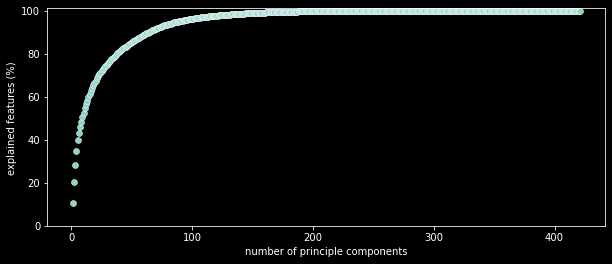

In [32]:
# ▶ 200개 PC까지 사용했을 때, 80%정도 분산을 설명할 수 있음
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

fig, ax = plt.subplots(figsize = (10,4))
xi = np.arange(1, data.shape[1]+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)*100

plt.ylim(0.0,101)
plt.xlabel('number of principle components')
plt.ylabel('explained features (%)')
sns.scatterplot(x=xi, y=y);